In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.modeling.models import CompoundNormSpectralModel, PowerLawNormPenSpectralModel

from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov(simulated_dataset = True)

## Single Cases

In [4]:
norm = 0.1
tilt = 0.025


from gammapy.modeling.models.IRF import IRFModel, ERecoIRFModel, IRFModels, EffAreaIRFModel

effareamodel = EffAreaIRFModel()
erecomodel = ERecoIRFModel()
IRFmodels = IRFModels(eff_area_model= effareamodel,
                      e_reco_model = erecomodel,
                             datasets_names = dataset_asimov.name)


print(IRFmodels.parameters.names)


sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        bias = 0,
                        resolution = 0,
                        rnd = False,
                        e_reco_creation=10)
dataset_cor_N = sys_d_cor.create_dataset_N(10)
dataset_cor = sys_d_cor.create_dataset()




zero = 1e-12

    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((6, 6))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/zero**2, 1/zero**2, 1/norm**2, 1/tilt**2])


dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix


# set bkg model:
import operator
compoundnorm  = CompoundNormSpectralModel(model1  = PowerLawNormSpectralModel(),
                                         model2 = PowerLawNormPenSpectralModel(),
                                         operator =  operator.mul)

bkg = FoVBackgroundModel(dataset_name=dataset_cor_N.name,
                        spectral_model = compoundnorm)
dataset_cor_N.models['dataset N-irf'].parameters.freeze_all()
models = Models(dataset_cor_N.models)
models.pop('dataset N-bkg')
models.append(bkg)
dataset_cor_N.models = models
dataset_cor_N.models['dataset N-bkg'].parameters['tilt_nuisance'].frozen = False
dataset_cor_N.models['dataset N-bkg'].parameters['tilt'].frozen = False

datasets_N  = [dataset_cor_N]
datasets  = [dataset_cor]


    
    
    
print(dataset_cor_N.models)
print(dataset_cor.models)    
    

['bias', 'resolution', 'norm_nuisance', 'tilt_nuisance', 'reference']
DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : dataset N-irf
  Datasets names            : dataset N
  EReco 

In [15]:
%%time
fitting = 1
if fitting :
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets[0])
    print("saving")
    for i, d in enumerate(datasets):
        path = f'data/2_model_{norm}_tilt_{tilt}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    path = f'data/2_model_{norm}_tilt_{tilt}.yml'
    datasets[0] = Dataset_load.load_dataset_N(datasets[0], path)        
        
        
   

saving
CPU times: user 1min 44s, sys: 7.69 s, total: 1min 52s
Wall time: 1min 52s


In [ ]:
%%time
fitting_N = 1
if fitting_N :
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run([datasets_N[0]])
    for i, d in enumerate(datasets_N):
        path = f'data/2_model_nui_{norm}_tilt_{tilt}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    path = f'data/2_model_nui_{norm}_tilt_{tilt}.yml'
    datasets_N[0] = Dataset_load.load_dataset_N(datasets_N[0], path, bkg_sys = True)        
    

In [7]:
print(datasets_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : i2anhLHD
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   1.00e-12   +/- 9.0e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : F_NFnV95-irf
  Datasets names            : F_NFnV95
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffA

# Stat Profiles

## Stat Profiles for BKG Norm

In [8]:
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [9]:
%%time
computing_norm = 0

if computing_norm :
    parameter = datasets[0].models[1].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile = fit.stat_profile([datasets[0]], parameter, reoptimize= True)
    stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
    with open('data/5_scan_norm.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile), file)
else:
    with open('data/5_scan_norm.yaml') as file:
        stat_profile = yaml.load( file, Loader=yaml.FullLoader)

    

CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 1.76 ms


In [10]:
%%time
if computing_norm :
    parameter = datasets_N[0].models[-1].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile_N = fit.stat_profile(datasets_N[0], parameter, reoptimize = True)
    stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
    with open('data/5_scan_norm_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N), file)
    for k in stat_profile_N:
        if "spectral" in k:
            key_name = "scale_scan"
            stat_profile_N[key_name] = stat_profile_N[k]      
else:
    with open('data/5_scan_norm_N.yaml') as file:
        stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)

    

CPU times: user 1.03 ms, sys: 430 µs, total: 1.46 ms
Wall time: 1.9 ms


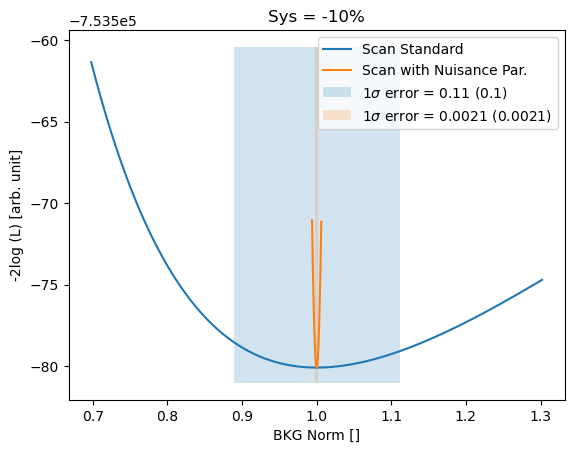

In [12]:
import upper_limit_18_02

fig = plt.figure()
ll_N = stat_profile_N.copy()
ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
L_N, x_N = ul_N.interpolate()
plt.plot(x_N, L_N(x_N),label ="Scan Standard")

ll = stat_profile.copy()
ul = upper_limit_18_02.upper_limit(ll,0,0)
L, x = ul.interpolate()
plt.plot(x, L(x),label ="Scan with Nuisance Par.")

norm_err_N = datasets_N[0].models.parameters['norm'].error
norm_err = datasets[0].models.parameters['norm'].error


min_, er, upp = ul_N.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2})')
min_, er, upp = ul.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err:.2})')

plt.xlabel("BKG Norm []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-4)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_norm.png")

In [13]:
## Stat Profiles for BKG Tilt

In [ ]:
%%time
computing_tilt = 1
if computing_tilt :
    parameter = datasets[0].models[1].parameters['tilt']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile = fit.stat_profile([datasets[0]], parameter, reoptimize= True)
    stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
    with open('data/5_scan_tilt.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile), file)
else:
    with open('data/5_scan_tilt.yaml') as file:
        stat_profile = yaml.load( file, Loader=yaml.FullLoader)

    

In [ ]:
%%time
if computing_tilt :
    parameter = datasets_N[0].models[-1].parameters['tilt']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile_N = fit.stat_profile(datasets_N[0], parameter, reoptimize = True)
    stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
    with open('data/5_scan_tilt_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N), file)
    for k in stat_profile_N:
        if "spectral" in k:
            key_name = "scale_scan"
            stat_profile_N[key_name] = stat_profile_N[k]      
else:
    with open('data/5_scan_tilt_N.yaml') as file:
        stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)

    

In [ ]:
import upper_limit_18_02

fig = plt.figure()
ll_N = stat_profile_N.copy()
ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
L_N, x_N = ul_N.interpolate()
plt.plot(x_N, L_N(x_N),label ="Scan Standard")

ll = stat_profile.copy()
ul = upper_limit_18_02.upper_limit(ll,0,0)
L, x = ul.interpolate()
plt.plot(x, L(x),label ="Scan with Nuisance Par.")

norm_err_N = datasets_N[0].models.parameters['norm'].error
norm_err = datasets[0].models.parameters['norm'].error


min_, er, upp = ul_N.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2})')
min_, er, upp = ul.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err:.2})')

plt.xlabel("BKG Tilt []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-4)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_tilt.png")

## Stat Profiles for Source Signal

In [ ]:
%%time
computing_amplitude = 0

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
%%time
if computing_amplitude:
    sigma = 3
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
print(datasets_N[0].models)

In [ ]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})')
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})')

plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_amplitude.png")

In [ ]:
ul_N_a.plot_interpolate()

## Stat Profiles for Source Index

In [ ]:
%%time
computing_index = 0

if computing_index:
    sigma = 2
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
%%time
computing_index_N = 0
if computing_index_N:
    sigma = 2
    parameter_i = datasets_N[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_index_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_index_N.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err:.2})')

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_index.png")